In [1]:
import random
import pandas as pd
import multiprocessing
import os
import shutil
from pathlib import Path

In [9]:
root = Path("/nobackup/nhaldert/objaverse")
root.mkdir(parents=True, exist_ok=True)

# 2. Set env var BEFORE importing objaverse
os.environ["BASE_PATH"] = str(root)
print("BASE_PATH set to:", os.environ["BASE_PATH"])

DATASET_DIR = "/u/nhaldert/work_dir/3d-image-generation/src/data"

import objaverse
objaverse.BASE_PATH = DATASET_DIR

BASE_PATH set to: /nobackup/nhaldert/objaverse


In [13]:
objaverse.BASE_PATH

'/u/nhaldert/work_dir/3d-image-generation/src/data'

In [11]:
annotations = objaverse.load_annotations()
all_uids = list(annotations.keys())
sample_uids = random.sample(all_uids, 3)
sample_uids

100%|██████████| 160/160 [00:39<00:00,  4.04it/s]


['b33e4aa47e0343c1a1e1354a2c26d333',
 'fa7137e218ea419dace27f83d48ebcd1',
 '154ce5f6f83747fbb1fa9dd96a61e39b']

In [12]:
objects = objaverse.load_objects(
    uids=sample_uids,
    download_processes=multiprocessing.cpu_count(),
)

starting download of 3 objects with 128 processes
Downloaded 1 / 3 objects
Downloaded 2 / 3 objects
Downloaded 3 / 3 objects


In [14]:
objects

{'b33e4aa47e0343c1a1e1354a2c26d333': '/u/nhaldert/.objaverse/hf-objaverse-v1/glbs/000-020/b33e4aa47e0343c1a1e1354a2c26d333.glb',
 'fa7137e218ea419dace27f83d48ebcd1': '/u/nhaldert/.objaverse/hf-objaverse-v1/glbs/000-097/fa7137e218ea419dace27f83d48ebcd1.glb',
 '154ce5f6f83747fbb1fa9dd96a61e39b': '/u/nhaldert/.objaverse/hf-objaverse-v1/glbs/000-122/154ce5f6f83747fbb1fa9dd96a61e39b.glb'}

In [83]:
import trimesh
from trimesh.sample import sample_surface

In [80]:
mesh = trimesh.load("/u/nhaldert/work_dir/3d-image-generation/src/data/hf-objaverse-v1/glbs/000-097/fa7137e218ea419dace27f83d48ebcd1.glb").to_mesh()
mesh.show()

In [87]:
type(mesh)

trimesh.base.Trimesh

In [134]:
mesh = trimesh.load("/u/nhaldert/work_dir/3d-image-generation/src/data/hf-objaverse-v1/glbs/000-097/fa7137e218ea419dace27f83d48ebcd1.glb").to_mesh()
mesh.visual = mesh.visual.to_color()
sample_points, face_indices, colors = trimesh.sample.sample_surface(mesh, 10000, sample_color=True)
sample_points

TrackedArray([[ 0.02499818,  9.89753415,  1.81867279],
              [ 1.20785572,  9.9139588 ,  0.89071916],
              [ 1.86472641, 10.23906289,  2.23185262],
              ...,
              [-0.96851711, 10.31406256,  2.93118513],
              [-0.52169872,  9.93633733,  3.18254512],
              [ 0.45945762, 10.05059371, -1.90828512]])

In [135]:
np.array(face_indices.tolist()).shape, np.array(sample_points.tolist()).shape, np.array(colors.tolist()).shape 
# dir(sampled_mesh)

((10000,), (10000, 3), (10000, 4))

In [111]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

In [143]:
# mesh = trimesh.mesh
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np.asarray(sample_points))
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
normals = np.asarray(pcd.normals)
np.asarray(pcd.points), np.asarray(pcd.normals)

(array([[ 0.02499818,  9.89753415,  1.81867279],
        [ 1.20785572,  9.9139588 ,  0.89071916],
        [ 1.86472641, 10.23906289,  2.23185262],
        ...,
        [-0.96851711, 10.31406256,  2.93118513],
        [-0.52169872,  9.93633733,  3.18254512],
        [ 0.45945762, 10.05059371, -1.90828512]]),
 array([[ 0.        ,  0.        ,  1.        ],
        [ 0.08298892,  0.9788774 ,  0.18684722],
        [-0.26419904,  0.93678964, -0.22939928],
        ...,
        [ 0.        ,  0.        ,  1.        ],
        [ 0.82799677,  0.40321206,  0.3896683 ],
        [ 0.56404143,  0.74672393, -0.35250623]]))

In [114]:
fx = fy = W * 0.8  # FOV ~60°
cx, cy = W/2, H/2
K = np.array([
    [fx, 0, cx], 
    [0, fy, cy], 
    [0, 0, 1]
])

R = np.array(
    [
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
    ]
)
T = np.array([0, 0, 3]) 

IndexError: index 3985 is out of bounds for axis 0 with size 1000

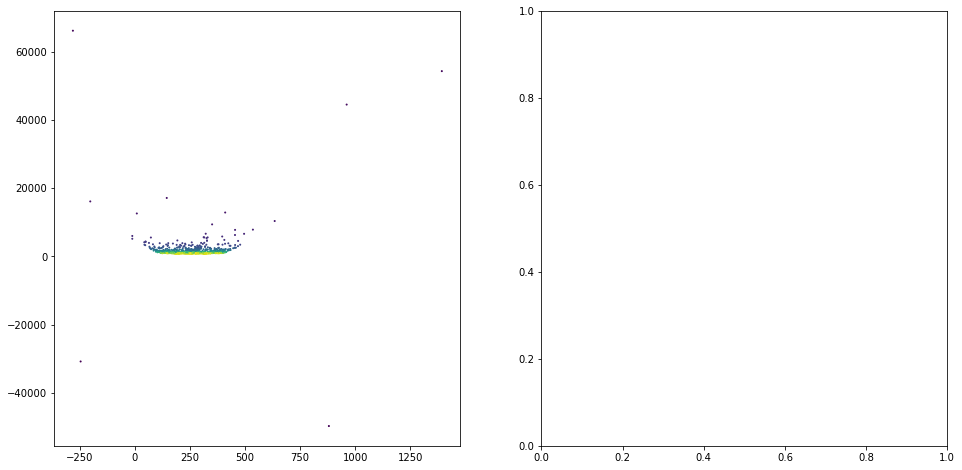

In [117]:
world_to_cam = np.hstack([R, T[:, np.newaxis]])  # 3x4
P = K @ world_to_cam  # 3x4 projection matrix

# === STEP 4: Project vertices to 2D ===
points_3d_homo = np.hstack([verts, np.ones((len(verts), 1))])  # (N,4)
points_2d_homo = (P @ points_3d_homo.T).T  # (N,3)
points_2d = points_2d_homo[:, :2] / points_2d_homo[:, 2:3]  # perspective divide (N,2)

# === STEP 5: Depth shading (z-buffer simulation) ===
depth = points_2d_homo[:, 2]  # depth values
depth_norm = (depth - depth.min()) / (depth.max() - depth.min() + 1e-8)
colors = plt.cm.viridis(depth_norm)[:, :3]  # RGB from depth

# === STEP 6: Render with Matplotlib ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Wireframe
ax1.scatter(points_2d[:, 0], points_2d[:, 1], c=colors, s=1)
for face in faces[:5000]:  # limit lines for speed
    ax1.plot(points_2d[face, 0], points_2d[face, 1], color=colors[face].mean(0), lw=0.3, alpha=0.6)
ax1.set_xlim(0, W); ax1.set_ylim(0, H)
ax1.invert_yaxis(); ax1.set_title('Wireframe + Depth'); ax1.axis('off')

# Filled triangles (rasterization)
ax2.scatter(points_2d[:, 0], points_2d[:, 1], c=colors, s=1)
for face in faces[:2000]:
    triangle = np.array([points_2d[f] for f in face])
    ax2.fill(triangle[:, 0], triangle[:, 1], color=colors[face].mean(0), alpha=0.7)
ax2.set_xlim(0, W); ax2.set_ylim(0, H)
ax2.invert_yaxis(); ax2.set_title('Filled + Depth'); ax2.axis('off')

plt.tight_layout()
plt.show()